# L41: Lab 1 - Getting started with kernel tracing - I/O

The goals of this lab are to:
    
- Introduce you to our experimental environment and DTrace.
- Have you explore user-kernel interactions via system calls and traps.
- Gain experience tracing I/O behaviour in UNIX.
- Develop an intuition about DTrace's probe effect.

You will do this using DTrace to analyse the behaviour of a potted, kernel-intensive block-I/O benchmark.

---
## Block-I/O benchmark

### Compiling the benchmark

In [1]:
# Extract and build the benchmark
!make -C io

### Running the benchmark

Once built, you can run the benchmark binaries as follows (with the command-line arguments specifying various benchmark parameters):

In [2]:
# Execute the io-static benchmark displaying the command line options
!io/io-static

io-static -c|-r|-w [-Bdqsv] [-b buffersize] [-t totalsize] path

Modes (pick one):
    -c              'create mode': create benchmark data file
    -r              'read mode': read() benchmark
    -w              'write mode': write() benchmark

Optional flags:
    -B              Run in bare mode: no preparatory activities
    -d              Set O_DIRECT flag to bypass buffer cache
    -q              Just run the benchmark, don't print stuff out
    -s              Call fsync() on the file descriptor when complete
    -v              Provide a verbose benchmark description
    -b buffersize    Specify a buffer size (default: 16384)
    -t totalsize    Specify total I/O size (default: 16777216)


In [3]:
# Execute the io-dynamic benchmark displaying the command line options
!io/io-dynamic

io-dynamic -c|-r|-w [-Bdqsv] [-b buffersize] [-t totalsize] path

Modes (pick one):
    -c              'create mode': create benchmark data file
    -r              'read mode': read() benchmark
    -w              'write mode': write() benchmark

Optional flags:
    -B              Run in bare mode: no preparatory activities
    -d              Set O_DIRECT flag to bypass buffer cache
    -q              Just run the benchmark, don't print stuff out
    -s              Call fsync() on the file descriptor when complete
    -v              Provide a verbose benchmark description
    -b buffersize    Specify a buffer size (default: 16384)
    -t totalsize    Specify total I/O size (default: 16777216)


### Example benchmark commands

The following example creates a default-sized benchmark data file (the benchmark data file is stored in the `/data` directory on the BeagleBone Black SD card):

In [4]:
# Example benchmark command
print_header("Creating file to run benchmark")

!io/io-static -c iofile

print_footer("Completed")

********************************************************************************
* Creating file to run benchmark
********************************************************************************
Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: iofile
  time: 1.908447458
8584.99 KBytes/sec
********************************************************************************
* Completed
********************************************************************************


The following example runs a simple `read()` benchmark on the benchmark data file, printing additional information (`-v`) about the benchmark run:

In [5]:
# Example benchmark command
print_header("Running benchmark")

!io/io-static -v -r iofile

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: read
  path: iofile
  time: 0.106160459
154332.42 KBytes/sec
********************************************************************************
* Completed
********************************************************************************


The following example runs a simple `write()` benchmark on the data file, printing additional information (`-v`) about the benchmark run:

In [6]:
# Example benchmark command
print_header("Running benchmark")

!io/io-static -v -w iofile

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: write
  path: iofile
  time: 1.610386750
10173.95 KBytes/sec
********************************************************************************
* Completed
********************************************************************************


The following example runs a simple write() benchmark multiple times printing out the average measured I/O bandwidth (KiBytes/sec):

In [7]:
# Example benchmark command
print_header("Running benchmark")

# Run the benchmark multiple times storing each measure bandwidth in values[]
values = []

for trials in range(0, 10):
    output = !io/io-static -w iofile
    values.append(float(output[0].split(' ')[0]))
    
# Compute and print the average I/O bandwidth
average_bw = sum(values)/len(values)
print("Average bandwidth = {} KiBytes/sec".format(average_bw))

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
Average bandwidth = 10603.616 KiBytes/sec
********************************************************************************
* Completed
********************************************************************************


When performing whole-program analysis using DTrace, be sure to suppress the benchmark's output (bare `-B`) mode as follows (this prevents DTrace from tracing the printing of the benchmark):

In [8]:
# Example benchmark
print_header("Running benchmark")

!io/io-static -B -q -r iofile

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
********************************************************************************
* Completed
********************************************************************************


The following example measures the performance of the read benchmark when the buffer cache is enabled and disable. As noted in the lab handouts, be sure to discard the ouput of the first run of the benchmark when the buffer cache is disabled (as cached data may still be  accessed):

In [9]:
# Example benchmark command
print_header("Running benchmark")

enabled = !io/io-static -r iofile
enabled_again = !io/io-static -r iofile
disabled = !io/io-static -d -r iofile

print("Buf. cache enabled: bandwidth = {} KiBytes/sec".
      format(float(enabled[0].split(' ')[0])))
print("Buf. cache enabled (2nd run): bandwidth = {} KiBytes/sec".
      format(float(enabled_again[0].split(' ')[0])))
print("Buf. cache disabled: bandwidth = {} KiBytes/sec".
      format(float(disabled[0].split(' ')[0])))

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
Buf. cache enabled: bandwidth = 172035.33 KiBytes/sec
Buf. cache enabled (2nd run): bandwidth = 172077.42 KiBytes/sec
Buf. cache disabled: bandwidth = 13182.97 KiBytes/sec
********************************************************************************
* Completed
********************************************************************************


To get a high-level summary of execution time (including a breakdown of total wall-clock time, time in userspace and "system-time") use the UNIX time command as follows:

In [10]:
# Example benchmark command
print_header("Running benchmark")

!time -p io/io-static -r -B -d -q iofile

print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
real 2.21
user 0.01
sys 0.32
********************************************************************************
* Completed
********************************************************************************


---
## DTrace

Experimentation with DTrace is best performed directly from within the shell:

```
ssh root@192.168.141.100
root@l41-beaglebone:~ # dtrace -n 'BEGIN { print("hello world"); }'
```

### python-dtrace

DTrace scripts can be ran within the Jupyter notebook with the assistance of the `python-dtrace` module. Note:  this is somewhat more involved that running the `dtrace` command from the shell as the script must be executed within a seperate thread.

The following example uses DTrace to measure the execution time of the benchmark:

In [11]:
# D Language script
io_performance_script = """
BEGIN {
   self->targetPid = -1;
}

proc:::exec-success
/execname == "io-static"/
{
   self->targetPid = pid;
   self->start = vtimestamp;
}

syscall::*exit:entry
/pid == self->targetPid/
{
   self->targetPid = -1;
   trace(vtimestamp - self->start);
}
"""

values = []

# Callback invoked to print the trace record
# (that is, printf("%u", vtimestamp - self->start))
def simple_out(value):
    values.append(int(value))
    
# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(io_performance_script,
                                    chew_func=lambda v: None,
                                    chewrec_func=lambda v: None,
                                    out_func=simple_out,
                                    walk_func=None,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Display header to indicate that the benchmarking has started
print_header(["Starting io-static read performance measurement"])

# Run the io-static benchmark    
TOTAL_SIZE = 16*1024*1024
BUFFER_SIZE = 8192

for trials in range(0, 10):
    output = !io/io-static -r -B -q -b {str(BUFFER_SIZE)} -t {str(TOTAL_SIZE)} iofile
        
# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()

# Compute and print the average time
average_time = sum(values[1:])/len(values[1:])
print("Average time = {} nsec".format(average_time))
print("Average bandwidth = {} KiBytes/sec".format((TOTAL_SIZE/1024)/(average_time/1e9)))

# Display footer to indicate that the benchmarking has finished
print_footer(["Finished io-static read performance measurement"])

********************************************************************************
* Starting io-static read performance measurement
********************************************************************************
Average time = 103690943 nsec
Average bandwidth = 158008.014258 KiBytes/sec
********************************************************************************
* Finished io-static read performance measurement
********************************************************************************


The following example uses DTrace to record the number of times each `syscall` is called by the `io-static` benchmark reading the benchmark data file:

In [12]:
# D Language script
io_syscall_script = """
syscall:::entry
/execname == "io-static"/
{
    @a[probefunc] = count();
}
"""

# Callback invoked to process the aggregation
from collections import defaultdict
values = defaultdict(int)

def simple_out(a, b, c, d):
    values[c[0]] += d

# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(io_syscall_script,
                                    walk_func=simple_out,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Display header to indicate that the benchmarking has started
print_header("Starting io-static read performance measurement")

# Run the io-static benchmark    
TOTAL_SIZE = 16*1024*1024
BUFFER_SIZE = 512

output_dtrace = !io/io-static -r -b {str(BUFFER_SIZE)} -t {str(TOTAL_SIZE)} iofile
        
# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()
    
# Print the syscalls and their frequency
print("Number of read() calls {}".format(values['read']))

# Display footer to indicate that the benchmarking has finished
print_footer("Finished io-static read performance measurement")

********************************************************************************
* Starting io-static read performance measurement
********************************************************************************
Number of read() calls 32768
********************************************************************************
* Finished io-static read performance measurement
********************************************************************************


The following example explores the performance impact of adding a predicate clause in a DTrace script:

In [13]:
# D Language scripts
io_syscall_script = """
syscall:::entry
/execname == "io-static"/
{
    @a[probefunc] = count();
}
"""

io_syscall_script_no_predicate = """
syscall:::entry
{
    @a[probefunc] = count();
}
"""

TOTAL_SIZE = 16*1024*1024
BUFFER_SIZE = 512
values = dict()

# Callback invoked to process the aggregation
def simple_out(a, b, c, d):
    key = c[0]
    count = d
    if key in values:
        values[key] += d
    else:
        values[key] = d

# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(io_syscall_script,
                                    chew_func=None,
                                    chewrec_func=None,
                                    walk_func=simple_out,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Display header to indicate that the benchmarking has started
print_header(["Starting io-static read performance measurement"])

# Run the io-static benchmark    
output_predicate = !io/io-static -r -b {str(BUFFER_SIZE)} -t {str(TOTAL_SIZE)} iofile
        
# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()

# Now run the benchmark again but without the predicate

# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(io_syscall_script_no_predicate,
                                    chew_func=None,
                                    chewrec_func=None,
                                    walk_func=simple_out,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Run the io-static benchmark    
output_no_predicate = !io/io-static -r -b {str(BUFFER_SIZE)} -t {str(TOTAL_SIZE)} iofile
        
# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()

# Print the performance of both runs
print("With predicate {} KiBytes/sec".format(output_predicate[0].split(' ')[0]))
print("Without predicate {} KiBytes/sec".format(output_no_predicate[0].split(' ')[0]))

# Display footer to indicate that the benchmarking has finished
print_footer(["Finished io-static read performance measurement"])

********************************************************************************
* Starting io-static read performance measurement
********************************************************************************
With predicate 22347.99 KiBytes/sec
Without predicate 20572.83 KiBytes/sec
********************************************************************************
* Finished io-static read performance measurement
********************************************************************************


---
## matplotlib and pandas

### Plot read performance (against buffer size)

The following example plots data read from a previous saved file. The example also demonstrates calcualtion of error bars using Python's `pandas` library. (Generating plots on the BeagleBone Black can be rather slow!)

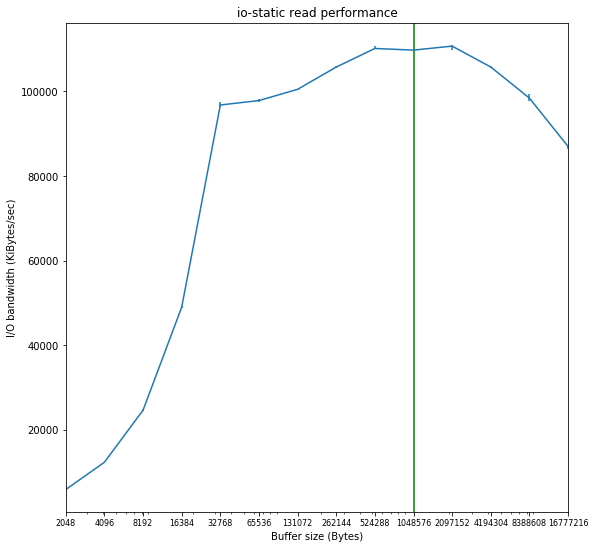

In [9]:
%matplotlib inline

# Plot the read performance (IO bandwidth against buffer size with error bars)
with open("2018-2019-l41-lab1.data", 'r') as f:
    content = f.readlines()
    
read_performance_values = [v.strip() for v in content]
       
# Buffer sizes to compute the performance with
BUFFER_SIZES = [2048 * 2 ** exp for exp in range(0, 14)]

# Total size of iofile (default size) = 16MiB
TOTAL_SIZE = BUFFER_SIZES[-1] #16*1024*1024

# Number of trials for each buffer size
NUM_TRIALS = 11

# Compute the IO bandwidth in KiBytes/sec
io_bandwidth_values = [(TOTAL_SIZE/1024)/(json.loads(val)["timestamp"]/1e9) for val in read_performance_values]

# Reshape the list into an array of size [len(BUFFER_SIZES), NUM_TRIALS]
io_bandwidth = np.reshape(io_bandwidth_values, (len(BUFFER_SIZES), NUM_TRIALS))[:,:]

# Convert the array of io bandwidth values into a Panda DataFrame
# this allows ploting of the median value and computation of the 
# error bars (25 and 75 percentile values)
# Note: The error bars should be small indicating that the experiment is tightly controlled
df = pd.DataFrame(io_bandwidth, index=BUFFER_SIZES)

# Compute error bars based on the 25 and 75 quartile values
error_bars = df.quantile([.25, .75], axis=1)
error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
error_bars_values = [error_bars.values]

# Create and label the plot
plt.figure();
df.median(1).plot(figsize=(9,9), yerr=error_bars_values, label="io-static read")
plt.title('io-static read performance')
plt.ylabel('I/O bandwidth (KiBytes/sec)')
plt.xlabel('Buffer size (Bytes)')
plt.xscale('log')
plt.xticks(BUFFER_SIZES, [str(b) for b in BUFFER_SIZES], fontsize=8)

# Plot a vertical line at 1MiB
plt.axvline(x=1024*1024, color='g')

# Display the plot and save it to a file
# (this can take a while (~30 secs) on the BeagleBone Black)
plt.savefig("2017-2018-l41-lab1-performance.pdf")

### Common functions and global variables

In [1]:
import math
import numpy as np
import time

def plot(datax, datay, filename, title, y_label, x_label):
    square = np.reshape(datay, (len(datax), 12))[:,:]
    df = pd.DataFrame(square, index=datax)
    print df

    # Compute error bars based on the 25 and 75 quartile values
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]

    # Create and label the plot
    plt.figure()
    df.median(1).plot(figsize=(9,9), yerr=error_bars_values, label=title)
    print df.median
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xscale('log')
    plt.xticks(datax, [str(data) for data in datax], fontsize=8)
#     plt.show()
    plt.savefig(filename)
    
def save(datay, filename):
    with open(filename, 'w') as f:
        for item in datay:
            f.write("%f\n" % item)
            
# Make sure the file has the correct size
!io/io-static -c -t 16777216 iofile
buffersizes = [int(math.pow(2, i)) for i in range(8, 25)]
filesizes =  [int(math.pow(2, i)) for i in range(14, 25)]

print('Done')

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: iofile
  time: 2.209030041
speed: 7416.83 KBytes/sec
Done


### First experiment --- varying buffer size

#### Methodology:

        1.From each measurement, collect information using time, throughput, benchmark time and DTrace.
        2.Perform the following measurements:
                * Read and Write
                * Vary buffer size logarithmically starting at 1B and finishing at 16MB


#### Static

In [22]:
print_header("Running benchmark")

print_header("Running time")
times = [[], [], []]
for buffersize in buffersizes:
    for i in range(12):
        output = !time -p io/io-static -r -B -q -b {str(buffersize)} iofile
        times[0].append(float(output[0].split(' ')[1]))
        times[1].append(float(output[1].split(' ')[1]))
        times[2].append(float(output[2].split(' ')[1]))
save(times[0], 'io-static-read-times-real.txt')
plot(buffersizes, times[0], 'io-static-read-times-real.png', 'IO-static time command: Real time', 'Time (ns)', 'Buffer size (B)')
save(times[1], 'io-static-read-times-user.txt')
plot(buffersizes, times[1], 'io-static-read-times-user.png', 'IO-static time command: User time', 'Time (ns)', 'Buffer size (B)')
save(times[2], 'io-static-read-times-sys.txt')
plot(buffersizes, times[2], 'io-static-read-times-sys.png', 'IO-static time command: System time', 'Time (ns)', 'Buffer size (B)')

print_header("Running throughput-time")
throughput_times = []    
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -B -v -b {str(buffersize)} iofile
        throughput_times.append(float(output[6].split(' ')[3]))
save(throughput_times, 'io-static-read-throughput-times.txt')
plot(buffersizes, throughput_times, 'io-static-read-throughput-times.png', 'IO-static: Time', 'Time (s)', 'Buffer size (B)')

print_header("Running throughput")
throughputs = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -B -b {str(buffersize)} iofile
        throughputs.append(float(output[0].split(' ')[0]))
save(throughputs, 'io-static-read-throughputs-no-readahead.txt')
plot(buffersizes, throughputs, 'io-static-read-throughputs.png', 'IO-static: Throughput', 'Throughput (KB/s)', 'Buffer size (B)')

print_header("Running throughput -d")
throughputs_d = []
# Ignore first run
output = !io/io-static -r -B -d iofile
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -B -d -b {str(buffersize)} iofile
        throughputs_d.append(float(output[0].split(' ')[0]))
save(throughputs_d, 'io-static-read-throughputs-d.txt')
plot(buffersizes, throughputs_d, 'io-static-read-throughputs-d.png', 'IO-static: Direct throughput', 'Throughput (KB/s)', 'Buffer size (B)')

print_header("Running throughput zero")
throughputs_zero = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -B -b {str(buffersize)} /dev/zero
        throughputs_zero.append(float(output[0].split(' ')[0]))
save(throughputs_zero, 'io-static-read-throughputs-zero.txt')
plot(buffersizes, throughputs_zero, 'io-static-read-throughputs-zero.png', 'IO-static: Throughput from /dev/zero', 'Throughput (KB/s)', 'Buffer size (B)')

print_header("Running throughput zero -d")
throughputs_zero_d = []
# Ignore first run
output = !io/io-static -r -B -d -b {str(buffersize)} /dev/zero
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -B -d -b {str(buffersize)} /dev/zero
        throughputs_zero_d.append(float(output[0].split(' ')[0]))
save(throughputs_zero_d, 'io-static-read-throughputs-zero-d.txt')
plot(buffersizes, throughputs_zero_d, 'io-static-read-throughputs-zero-d.png', 'IO-static: Direct throughput from /dev/zero', 'Throughput (KB/s)', 'Buffer size  (B)')

print_header("Running throughput without -B")
throughputs_B = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-static -r -b {str(buffersize)} iofile
        throughputs_B.append(float(output[0].split(' ')[0]))
save(throughputs_B, 'io-static-read-throughputs-b.txt')
plot(buffersizes, throughputs_B, 'io-static-read-throughputs-b.png', 'IO-static: Throughput without -B flag', 'Throughput (KB/s)', 'Buffer size (B)')
        
print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
********************************************************************************
* Running time
********************************************************************************
********************************************************************************
* Running throughput-time
********************************************************************************
********************************************************************************
* Running throughput
********************************************************************************
********************************************************************************
* Running throughput -d
********************************************************************************
********************************************************************************
* R

In [8]:
print_header("Running DTrace")

def dtrace(script, array):

    dtrace_aggregate = [[0 for i in range(len(buffersizes))] for i in range(12)]
    count_attempt = 0
    count_buffer = 0

    def simple_out(a, b, c, d):
    #     print a,b,c,d
        dtrace_aggregate[count_buffer][count_attempt] += d

    for buffersize in buffersizes:
        for i in range(12):
            dtrace_thread = DTraceConsumerThread(script,
                                                chew_func=None,
                                                chewrec_func=None,
                                                walk_func=simple_out,
                                                sleep=1)
            dtrace_thread.start()
            output = !io/io-static -r -B -b {str(buffersize)} iofile
            print output
            dtrace_thread.stop()
            dtrace_thread.join()
            count_attempt = (count_attempt + 1) % 12
        array = array + dtrace_aggregate[count_buffer]
        count_buffer = (count_buffer + 1) % 12
    
    return array
        
read_script = """
syscall::read:entry
/execname == "io-static"/
{
    self->rstart = vtimestamp;
}

syscall::read:return
/execname == "io-static"/
{
    @reads = sum(vtimestamp - self->rstart);
}
"""
# read_times = dtrace(read_script, [])
# print read_times

fbt_script = """
fbt::cluster_read:entry
/execname == "io-static"/
{ self->t = vtimestamp; }
fbt::cluster_read:return
/execname == "io-static" && self->t/
{@ = sum(vtimestamp - self->t); self->t = 0;}
"""
# fbt_times = dtrace(fbt_script, [])
# print fbt_times
# plt.plot(buffersizes, fbt_times)
# plt.xscale('log')
# plt.savefig('breadn_flags.png')


cluster_script = """
fbt::cluster_read:entry /execname == "io-static"/ { @ = count()}
"""
cluster_times = dtrace(cluster_script, [])
save(cluster_times)
plot(buffersizes, cluster_times, 'io-static-cluster-counts.png', 'IO-static: cluster_read call numbers', 'Number of calls', 'Buffer size')
# print cluster_times 
# plt.plot(buffersizes, cluster_times)
# plt.xscale('log')
# plt.savefig('cluster_read.png')
# save(cluster_times, 'cluster_read.txt')

# plot(buffersizes, dtrace_times, 'io-static-read-dtrace-times.png')

print_footer("Completed")

********************************************************************************
* Running DTrace
********************************************************************************
['14387.11 KBytes/sec']


NameError: global name 'count_attampt' is not defined

#### Dynamic

In [24]:
print_header("Running benchmark")

print_header("Running time")
times = [[], [], []]
for buffersize in buffersizes:
    for i in range(12):
        output = !time -p io/io-dynamic -r -B -q -b {str(buffersize)} iofile
        times[0].append(float(output[0].split(' ')[1]))
        times[1].append(float(output[1].split(' ')[1]))
        times[2].append(float(output[2].split(' ')[1]))
save(times[0], 'io-dynamic-read-times-real.txt')
plot(buffersizes, times[0], 'io-dynamic-read-times-real.png', 'IO-dynamic time command: Real time', 'Time (ns)', 'Buffer size')
save(times[1], 'io-dynamic-read-times-user.txt')
plot(buffersizes, times[1], 'io-dynamic-read-times-user.png', 'IO-dynamic time command: User time', 'Time (ns)', 'Buffer size')
save(times[2], 'io-dynamic-read-times-sys.txt')
plot(buffersizes, times[2], 'io-dynamic-read-times-sys.png', 'IO-dynamic time command: System time', 'Time (ns)', 'Buffer size')

print_header("Running throughput-time")
throughput_times = []    
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -v -b {str(buffersize)} iofile
        throughput_times.append(float(output[6].split(' ')[3]))
save(throughput_times, 'io-dynamic-read-throughput-times.txt')
plot(buffersizes, throughput_times, 'io-dynamic-read-throughput-times.png', 'IO-dynamic: Time', 'Time (s)', 'Buffer size')

print_header("Running throughput")
throughputs = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -b {str(buffersize)} iofile
        throughputs.append(float(output[0].split(' ')[0]))
save(throughputs, 'io-dynamic-read-throughputs-no-readahead.txt')
plot(buffersizes, throughputs, 'io-dynamic-read-throughputs.png', 'IO-dynamic: Throughput', 'Throughput (KB/s)', 'Buffer size')

# print_header("Running throughput -d")
# throughputs_d = []
# # Ignore first run
# output = !io/io-static -r -B -d iofile
# for buffersize in buffersizes:
#     for i in range(12):
#         output = !io/io-dynamic -r -B -d -b {str(buffersize)} iofile
#         throughputs_d.append(float(output[0].split(' ')[0]))
# save(throughputs_d, 'io-dynamic-read-throughputs-d.txt')
# plot(buffersizes, throughputs_d, 'io-dynamic-read-throughputs-d.png', 'IO-dynamic: Direct throughput', 'Throughput (KB/s)', 'Buffer size')

print_header("Running throughput zero")
throughputs_zero = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -b {str(buffersize)} /dev/zero
        throughputs_zero.append(float(output[0].split(' ')[0]))
save(throughputs_zero, 'io-dynamic-read-throughputs-zero.txt')
plot(buffersizes, throughputs_zero, 'io-dynamic-read-throughputs-zero.png', 'IO-dynamic: Throughput from /dev/zero', 'Throughput (KB/s)', 'Buffer size')

print_header("Running throughput zero -d")
throughputs_zero_d = []
# Ignore first run
output = !io/io-dynamic -r -B -d -b {str(buffersize)} /dev/zero
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -d -b {str(buffersize)} /dev/zero
        throughputs_zero_d.append(float(output[0].split(' ')[0]))
save(throughputs_zero_d, 'io-dynamic-read-throughputs-zero-d.txt')
plot(buffersizes, throughputs_zero_d, 'io-dynamic-read-throughputs-zero-d.png', 'IO-dynamic: Direct throughput from /dev/zero', 'Throughput (KB/s)', 'Buffer size')

print_header("Running throughput without -B")
throughputs_B = []
for buffersize in buffersizes:
    for i in range(12):
        output = !io/io-dynamic -r -b {str(buffersize)} iofile
        throughputs_B.append(float(output[0].split(' ')[0]))
save(throughputs_B, 'io-dynamic-read-throughputs-b.txt')
plot(buffersizes, throughputs_B, 'io-dynamic-read-throughputs-b.png', 'IO-dynamic: Throughput without -B flag', 'Throughput (KB/s)', 'Buffer size')
        
print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
********************************************************************************
* Running time
********************************************************************************
********************************************************************************
* Running throughput-time
********************************************************************************
********************************************************************************
* Running throughput
********************************************************************************
********************************************************************************
* Running throughput zero
********************************************************************************
********************************************************************************
*

### Second experiment --- file size

In [9]:
!io/io-static -c -t 16777216 iofile

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: iofile
  time: 1.619815625
10114.73 KBytes/sec


#### Static

In [20]:
print_header("Running benchmark")

print_header("Running time")
times = [[], [], []]
for filesize in filesizes:
    for i in range(12):
        output = !time -p io/io-static -r -B -q -t {str(filesize)} iofile
        times[0].append(float(output[0].split(' ')[1]))
        times[1].append(float(output[1].split(' ')[1]))
        times[2].append(float(output[2].split(' ')[1]))
save(times[0], 'io-static-file-read-times-real.txt')
plot(filesizes, times[0], 'io-static-file-read-times-real.png', 'IO-static time command: Real time', 'Time (ns)', 'File size (B)')
save(times[1], 'io-static-file-read-times-user.txt')
plot(filesizes, times[1], 'io-static-file-read-times-user.png', 'IO-static time command: User time', 'Time (ns)', 'File size (B)')
save(times[2], 'io-static-file-read-times-file-sys.txt')
plot(filesizes, times[2], 'io-static-file-read-times-sys.png', 'IO-static time command: System time', 'Time (ns)', 'File size (B)')

print_header("Running throughput-time")
throughput_times = []    
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -B -v -t {str(filesize)} iofile
        throughput_times.append(float(output[6].split(' ')[3]))
save(throughput_times, 'io-static-file-read-throughput-times.txt')
plot(filesizes, throughput_times, 'io-static-file-read-throughput-times.png', 'IO-static: Time', 'Time (s)', 'File size (B)')

print_header("Running throughput")
throughputs = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -B -t {str(filesize)} iofile
        throughputs.append(float(output[0].split(' ')[0]))
save(throughputs, 'io-static-file-read-throughputs-no-readahead.txt')
plot(filesizes, throughputs, 'io-static-file-read-throughputs.png', 'IO-static: Throughput', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput -d")
throughputs_d = []
# Ignore first run
output = !io/io-static -r -B -d iofile
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -B -d -t {str(filesize)} iofile
        throughputs_d.append(float(output[0].split(' ')[0]))
save(throughputs_d, 'io-static-file-read-throughputs-d.txt')
plot(filesizes, throughputs_d, 'io-static-file-read-throughputs-d.png', 'IO-static: Direct throughput', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput zero")
throughputs_zero = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -B -t {str(filesize)} /dev/zero
        throughputs_zero.append(float(output[0].split(' ')[0]))
save(throughputs_zero, 'io-static-read-throughputs-zero.txt')
plot(filesizes, throughputs_zero, 'io-static-file-read-throughputs-zero.png', 'IO-static: Throughput from /dev/zero', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput zero -d")
throughputs_zero_d = []
# Ignore first run
output = !io/io-static -r -B -d /dev/zero
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -B -d -t {str(filesize)} /dev/zero
        throughputs_zero_d.append(float(output[0].split(' ')[0]))
save(throughputs_zero_d, 'io-static-file-read-throughputs-zero-d.txt')
plot(filesizes, throughputs_zero_d, 'io-static-file-read-throughputs-zero-d.png', 'IO-static: Direct throughput from /dev/zero', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput without -B")
throughputs_B = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-static -r -t {str(filesize)} iofile
        throughputs_B.append(float(output[0].split(' ')[0]))
save(throughputs_B, 'io-static-file-read-throughputs-b.txt')
plot(filesizes, throughputs_B, 'io-static-file-read-throughputs-b.png', 'IO-static: Throughput without -B flag', 'Throughput (KB/s)', 'Buffer size (B)')

        
print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
********************************************************************************
* Completed
********************************************************************************


In [10]:
filesizes

[16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216]

#### Dynamic

In [25]:
print_header("Running benchmark")

print_header("Running time")
times = [[], [], []]
for filesize in filesizes:
    for i in range(12):
        output = !time -p io/io-dynamic -r -B -q -t {str(filesize)} iofile
        times[0].append(float(output[0].split(' ')[1]))
        times[1].append(float(output[1].split(' ')[1]))
        times[2].append(float(output[2].split(' ')[1]))
save(times[0], 'io-dynamic-file-read-times-real.txt')
plot(filesizes, times[0], 'io-dynamic-file-read-times-real.png', 'IO-dynamic time command: Real time', 'Time (ns)', 'File size (B)')
save(times[1], 'io-dynamic-file-read-times-user.txt')
plot(filesizes, times[1], 'io-dynamic-file-read-times-user.png', 'IO-dynamic time command: User time', 'Time (ns)', 'File size (B)')
save(times[2], 'io-dynamic-file-read-times-file-sys.txt')
plot(filesizes, times[2], 'io-dynamic-file-read-times-sys.png', 'IO-dynamic time command: System time', 'Time (ns)', 'File size (B)')

print_header("Running throughput-time")
throughput_times = []    
for filesize in filesizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -v -t {str(filesize)} iofile
        throughput_times.append(float(output[6].split(' ')[3]))
save(throughput_times, 'io-dynamic-file-read-throughput-times.txt')
plot(filesizes, throughput_times, 'io-dynamic-file-read-throughput-times.png', 'IO-dynamic: Time', 'Time (s)', 'File size (B)')

print_header("Running throughput")
throughputs = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -t {str(filesize)} iofile
        throughputs.append(float(output[0].split(' ')[0]))
save(throughputs, 'io-dynamic-file-read-throughputs-no-readahead.txt')
plot(filesizes, throughputs, 'io-dynamic-file-read-throughputs-no-readahead.png', 'IO-dynamic: Throughput', 'Throughput (KB/s)', 'File size (B)')

# print_header("Running throughput -d")
# throughputs_d = []
# # Ignore first run
# output = !io/io-dynamic -r -B -d iofile
# for filesize in filesizes:
#     for i in range(12):
#         output = !io/io-dynamic -r -B -d -t {str(filesize)} iofile
#         throughputs_d.append(float(output[0].split(' ')[0]))
# save(throughputs_d, 'io-dynamic-file-read-throughputs-d.txt')
# plot(filesizes, throughputs_d, 'io-dynamic-file-read-throughputs-d.png', 'IO-dynamic: Direct throughput', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput zero")
throughputs_zero = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -t {str(filesize)} /dev/zero
        throughputs_zero.append(float(output[0].split(' ')[0]))
save(throughputs_zero, 'io-dynamic-file-read-throughputs-zero.txt')
plot(filesizes, throughputs_zero, 'io-dynamic-file-read-throughputs-zero.png', 'IO-dynamic: Throughput from /dev/zero', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput zero -d")
throughputs_zero_d = []
# Ignore first run
output = !io/io-static -r -B -d /dev/zero
for filesize in filesizes:
    for i in range(12):
        output = !io/io-dynamic -r -B -d -t {str(filesize)} /dev/zero
        throughputs_zero_d.append(float(output[0].split(' ')[0]))
save(throughputs_zero_d, 'io-dynamic-file-read-throughputs-zero-d.txt')
plot(filesizes, throughputs_zero_d, 'io-dynamic-file-read-throughputs-zero-d.png', 'IO-dynamic: Direct throughput from /dev/zero', 'Throughput (KB/s)', 'File size (B)')

print_header("Running throughput without -B")
throughputs_B = []
for filesize in filesizes:
    for i in range(12):
        output = !io/io-dynamic -r -t {str(filesize)} iofile
        throughputs_B.append(float(output[0].split(' ')[0]))
save(throughputs_B, 'io-dynamic-file-read-throughputs-b.txt')
plot(filesizes, throughputs_B, 'io-dynamic-file-read-throughputs-md.png', 'IO-dynamic: Throughput from /dev/zero', 'Throughput (KB/s)', 'Buffer size (B)')
        
print_footer("Completed")

********************************************************************************
* Running benchmark
********************************************************************************
********************************************************************************
* Running time
********************************************************************************
********************************************************************************
* Running throughput-time
********************************************************************************
********************************************************************************
* Running throughput
********************************************************************************
********************************************************************************
* Running throughput zero
********************************************************************************
********************************************************************************
*

In [15]:
for filesize in filesizes:
    discard = !io/io-static -c -t {str(filesize)} iofile
    discard = !io/io-static -r -B -d -t {str(filesize)} iofile
    output = !io/io-static -r -B -d -t {str(filesize)} iofile
    print(output)

['speed: 64289.30 KBytes/sec']
['speed: 15375.69 KBytes/sec']
['speed: 112280.71 KBytes/sec']
['speed: 7181.23 KBytes/sec']
['speed: 7678.21 KBytes/sec']
['speed: 8080.09 KBytes/sec']
['speed: 7974.07 KBytes/sec']
['speed: 3675.97 KBytes/sec']
['speed: 5735.99 KBytes/sec']
['speed: 6370.41 KBytes/sec']
['speed: 7057.49 KBytes/sec']


In [46]:
# print_header("Running throughput -d")
# misc_throughputs_d = []
# # Ignore first run
# output = !io/io-static -r -B -d iofile
# for filesize in filesizes:
#     for i in range(12):
#         output = !io/io-static -r -B -d -t {str(filesize)} iofile
#         misc_throughputs_d.append(float(output[0].split(' ')[0]))
#         print output
# print misc_throughputs_d

square = np.reshape(misc_throughputs_d, (len(filesizes), 12))[:,:]
df = pd.DataFrame(square, index=filesizes)
print df

# Compute error bars based on the 25 and 75 quartile values
error_bars = df.quantile([.25, .75], axis=1)
error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
error_bars_values = [error_bars.values]

# Create and label the plot
plt.figure()
df.median(1).plot(figsize=(9,9), yerr=error_bars_values, label='A')
print df.median
plt.title('A')
plt.ylabel('B')
plt.xlabel('C')
plt.xscale('log')
plt.xticks(datax, [str(data) for data in filesizes], fontsize=8)
plt.show()

# plot(filesizes, misc_throughputs_d, 'misc-throughputs-d.png', 'IO-static: Direct throughput', 'Throughput (KB/s)', 'File size (B)')

               0        1        2        3        4        5        6   \
16384     1679.41  3571.56  3617.25  2346.87  3574.39  3557.00  3564.96   
32768     4735.98  4730.78  4894.74  4868.52  4918.88  4898.21  4880.31   
65536     4193.48  6218.98  6191.93  6251.30  6198.95  6241.62  6049.67   
131072    4453.35  7167.91  6966.35  7003.48  7147.01  6988.30  6962.53   
262144    6371.52  7617.84  7658.86  7644.90  7016.18  6998.68  7642.09   
524288    5984.86  7910.59  7932.30  7918.04  7567.32  7933.89  7953.82   
1048576   8054.41  7975.66  7972.53  7797.37  7789.83  7957.19  7920.90   
2097152   8097.21  8005.00  8097.77  7999.92  7964.80  7989.61  8087.37   
4194304   7974.36  8193.85  8172.58  8135.17  8201.21  8203.62  8156.52   
8388608   8016.64  8223.78  8243.60  8235.09  8230.57  8234.62  8209.88   
16777216  8433.76  8167.23  8110.85  8169.66  8106.48  8185.32  8187.45   

               7        8        9        10       11  
16384     3615.51  3645.20  3555.42  3573.7

NameError: name 'datax' is not defined